# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df = pd.read_csv('bikes_rent.csv')
df.head()

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600

Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

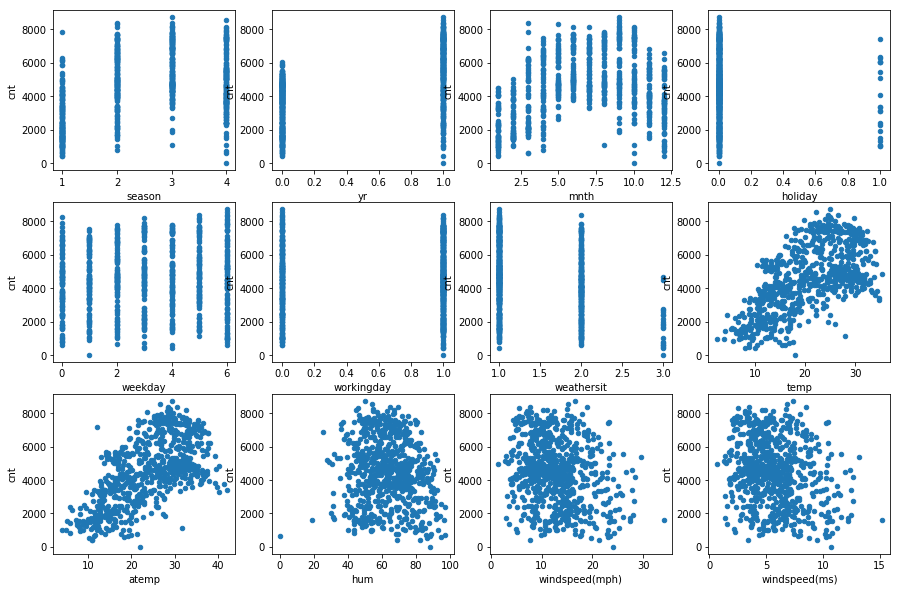

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * __ответ: очевидно, что зависимость есть; она не линейна; число прокатов объяснимо достигает максимума в летние месяцы__
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * __ответ: temp, atemp__

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [4]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df.drop('cnt', axis=1).corrwith(df['cnt']).sort_values(ascending=False)

atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
mnth              0.279977
weekday           0.067443
workingday        0.061156
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
weathersit       -0.297391
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [5]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [6]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [8]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
lr = LinearRegression()
lr.fit(X,y)

# Результат оберну в pd.DataFrame чтоб было красивее 
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame(zip(df.columns, lr.coef_))

0                      1
0           season                 570.87
1               yr               1,021.96
2             mnth                -141.30
3          holiday                 -86.76
4          weekday                 137.23
5       workingday                  56.39
6       weathersit                -330.23
7             temp                 367.47
8            atemp                 585.56
9              hum                -145.61
10  windspeed(mph)  12,458,830,091,266.61
11   windspeed(ms) -12,458,830,091,465.06

Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [11]:
from sklearn.linear_model import Lasso, Ridge

In [12]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X,y)
pd.DataFrame(zip(df.columns, lasso.coef_))

0        1
0           season   560.24
1               yr 1,019.46
2             mnth  -128.73
3          holiday   -86.15
4          weekday   137.35
5       workingday    55.21
6       weathersit  -332.37
7             temp   376.36
8            atemp   576.53
9              hum  -144.13
10  windspeed(mph)  -197.14
11   windspeed(ms)    -0.00

In [13]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X,y)
pd.DataFrame(zip(df.columns, ridge.coef_))

0        1
0           season   563.06
1               yr 1,018.95
2             mnth  -131.87
3          holiday   -86.75
4          weekday   138.01
5       workingday    55.90
6       weathersit  -332.35
7             temp   386.46
8            atemp   566.35
9              hum  -145.07
10  windspeed(mph)   -99.26
11   windspeed(ms)   -99.26

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [14]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.

from IPython.display import display

# чтоб не копировать похожий код переберу методы по списку
for RegressionMethod, coefs in [(Lasso, coefs_lasso), (Ridge, coefs_ridge)]:
    for i, alpha in enumerate(alphas):
        r = RegressionMethod(alpha=alpha)
        coefs[i] = r.fit(X,y).coef_
    table = pd.DataFrame(coefs, columns=df.drop('cnt', axis=1).columns)
    table.insert(0, 'alpha', alphas)
    print RegressionMethod.__name__
    display(table)

Lasso


alpha  season       yr    mnth  holiday  weekday  workingday  weathersit  \
0      1  560.24 1,019.46 -128.73   -86.15   137.35       55.21     -332.37   
1     51  410.97   977.02   -0.00   -53.45    91.94       17.54     -318.13   
2    101  370.08   935.95    0.00   -12.16    48.89        0.00     -308.81   
3    151  332.84   891.87    0.00    -0.00     0.00        0.00     -279.62   
4    201  298.13   845.65    0.00    -0.00     0.00        0.00     -235.57   
5    251  258.93   799.24    0.00    -0.00     0.00        0.00     -190.82   
6    301  217.43   752.72    0.00    -0.00     0.00        0.00     -145.71   
7    351  175.93   706.20    0.00    -0.00     0.00        0.00     -100.61   
8    401  134.63   659.63    0.00    -0.00     0.00        0.00      -55.51   
9    451   93.35   613.05    0.00    -0.00     0.00        0.00      -10.42   

    temp  atemp     hum  windspeed(mph)  windspeed(ms)  
0 376.36 576.53 -144.13         -197.14          -0.00  
1 322.83 610.03  -91.07         -145.07          -0.00  
2 269.42 632.50  -27.50          -93.77          -0.00  
3 211.05 662.92   -0.00          -50.16          -0.00  
4 124.14 725.38   -0.00          -12.65          -0.00  
5  72.08 750.36   -0.00           -0.00          -0.00  
6  37.72 756.30   -0.00           -0.00          -0.00  
7   3.66 761.93   -0.00           -0.00          -0.00  
8   0.00 737.35   -0.00           -0.00          -0.00  
9   0.00 709.13   -0.00           -0.00          -0.00

Ridge


alpha  season       yr    mnth  holiday  weekday  workingday  weathersit  \
0      1  563.06 1,018.95 -131.87   -86.75   138.01       55.90     -332.35   
1     51  461.18   954.31  -41.57   -84.91   126.60       54.25     -313.28   
2    101  403.98   898.08    5.67   -81.91   117.94       52.73     -298.41   
3    151  366.60   848.46   34.03   -78.77   110.68       51.26     -286.13   
4    201  339.75   804.25   52.49   -75.72   104.40       49.84     -275.49   
5    251  319.16   764.56   65.15   -72.82    98.88       48.48     -266.00   
6    301  302.64   728.71   74.14   -70.10    93.96       47.19     -257.39   
7    351  288.91   696.15   80.66   -67.55    89.53       45.94     -249.47   
8    401  277.21   666.43   85.46   -65.18    85.52       44.76     -242.12   
9    451  267.03   639.20   89.01   -62.96    81.86       43.62     -235.26   

    temp  atemp     hum  windspeed(mph)  windspeed(ms)  
0 386.46 566.35 -145.07          -99.26         -99.26  
1 458.90 481.44 -151.29         -101.63        -101.63  
2 455.29 467.43 -152.69         -102.10        -102.10  
3 447.48 455.75 -151.48         -102.01        -102.01  
4 438.51 444.76 -148.94         -101.59        -101.59  
5 429.21 434.24 -145.70         -100.96        -100.96  
6 419.93 424.12 -142.09         -100.21        -100.21  
7 410.80 414.41 -138.32          -99.36         -99.36  
8 401.91 405.09 -134.50          -98.45         -98.45  
9 393.30 396.14 -130.71          -97.49         -97.49

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5,1,'Ridge')

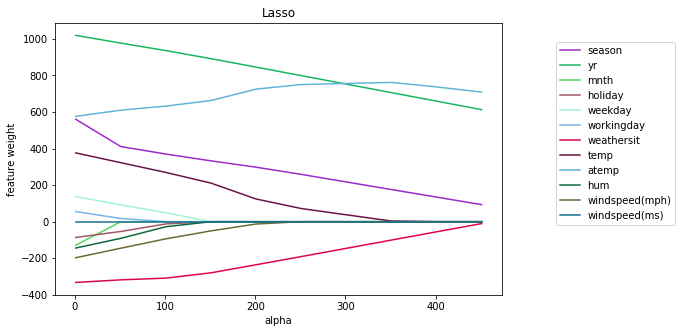

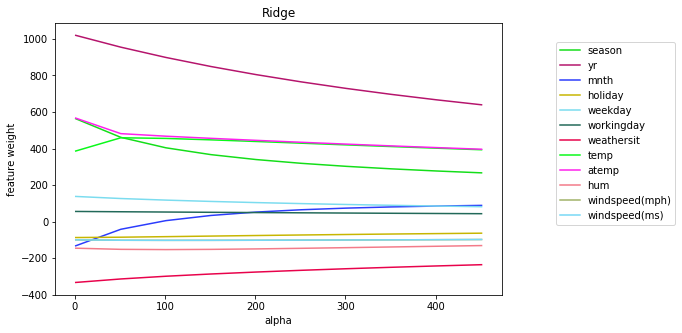

In [15]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * __Ответ: Lasso__
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * __Ответ: все веса станут == 0__
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * __Ответ: про Lasso - правда. Ridge в нашем случае и не исключил ни одного признака ни при одном значении alpha из заданного диапазона __
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * __Ответ: Lasso__

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [16]:
from sklearn.linear_model import LassoCV

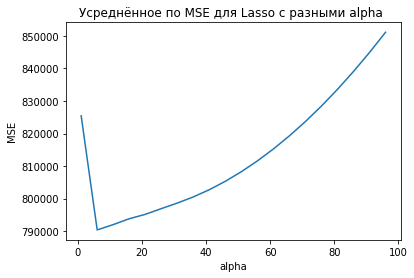


Оптимальное значение alpha: 6
(при более мелком шаге значение будет ближе к 4.2)


[('season', 532.0189828413535),
 ('yr', 1015.0602226430601),
 ('mnth', -100.0395261435663),
 ('holiday', -83.29395987529922),
 ('weekday', 132.50446549095798),
 ('workingday', 51.55708561407379),
 ('weathersit', -330.55985673998146),
 ('temp', 370.6798550300354),
 ('atemp', 581.3969310654965),
 ('hum', -140.00740550068858),
 ('windspeed(mph)', -191.7714084713507),
 ('windspeed(ms)', -2.6854541815693778e-08)]

In [17]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
lassoCv = LassoCV(alphas=alphas)
lassoCv.fit(X, y)

averageMse = lassoCv.mse_path_.mean(axis=1)
plt.plot(lassoCv.alphas_, averageMse)
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title(u"Усреднённое по MSE для Lasso с разными alpha ")
plt.show()

print('\nОптимальное значение alpha: {}'.format(lassoCv.alpha_))
print('(при более мелком шаге значение будет ближе к 4.2)')

display(zip(df.drop('cnt', axis=1).columns, lassoCv.coef_))

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Минимальное значение alpha для блока 0: 41
Минимальное значение alpha для блока 1: 6
Минимальное значение alpha для блока 2: 1


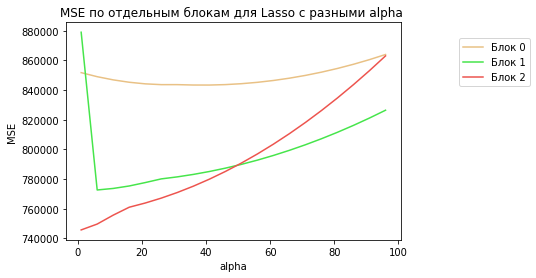

In [18]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
plt.figure()
for i in range(lassoCv.mse_path_.shape[1]):
    plt.plot(lassoCv.alphas_, lassoCv.mse_path_[:,i], label=u'Блок {}'.format(i), color=np.random.rand(3))
    # Найдём alзрa соответствующее минимальному MSE
    c = lassoCv.mse_path_[:,i]
    minAlpha = dict(zip(c, lassoCv.alphas_))[c.min()]
    print u'Минимальное значение alpha для блока {}: {}'.format(i, minAlpha)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title(u"MSE по отдельным блокам для Lasso с разными alpha ")
plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * __Ответ: наибольшие коэфициенты у сезона, года и температуры (реальной и ощущаемой). Эта зависимость видна на графиках и объяснима: люди чаще катаются в определённые сезоны года и в хорошую погоду, а так же спрос на велосепеды растёт год от года__
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * __Ответ: weathersit, windspeed(mph), hum. Это логично, т.к. чем выше значение каждого из этих признаков, тем хуже погода и меньше желание людей хотят взять велосипед. Убывающия зависимость вырвжена слабее чем в предыдущем вопросе, тем не менее на графиках она тоже видна__
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * __Ответ: windspeed(ms). Этот признак линейно зависит от windspeed(mph) и не вносит дополнительной информации, потому он и исключён. Это видно по графикам: они одинаковые при правильно подобраном масштабе. Сказать что признак не влияет на спрос нельзя, дело не в этом.__

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.